# 3. Gráficos complementares

Gráficos para complementarem a apresentação do case

### importando as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from scipy.stats import f_oneway

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

%matplotlib inline

### lendo as bases tratadas

In [2]:
demographic_data = pd.read_csv('dados_tratados/demographic_data_trat.csv')
df_geocode = pd.read_csv('dados_tratados/df_geocode_trat.csv')
economic_data = pd.read_csv('dados_tratados/economic_data_trat.csv')
test_data = pd.read_csv('dados_tratados/test_data_trat.csv')
transactional_data = pd.read_csv('dados_tratados/transactional_data_trat.csv')

zipcodes_states = pd.read_excel('dados_brutos/zipcodes-states.xlsx', index_col = 0) # fontes: https://codigo-postal.co/pt-br/eua/, https://pt.wikipedia.org/wiki/Lista_de_estados_dos_Estados_Unidos_por_popula%C3%A7%C3%A3o

c:\Users\Leticia\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning:

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.



### gráfico do número de exames por mês - versão em linhas

In [3]:
exames_mes = transactional_data

exames_mes['Date of service'] = pd.to_datetime(exames_mes['Date of service'])

exames_mes['mes'] = exames_mes['Date of service'].dt.strftime('%b')
exames_mes['ano'] = exames_mes['Date of service'].dt.strftime('%y')

ordem = exames_mes.sort_values('Date of service')[['mes', 'ano']].drop_duplicates()
ordem['mes_ano'] = ordem['mes'] + '/' + ordem['ano']

ordem = ordem.reset_index().reset_index()
ordem = ordem.drop(['index'], axis = 1)
ordem = ordem.rename({'level_0':'mes_ordem'}, axis = 1)
ordem['mes_ordem'] = ordem['mes_ordem'] + 1

exames_mes2 = exames_mes
exames_mes2['mes_ano'] = exames_mes2['mes'] + '/' + exames_mes2['ano']
exames_mes2 = exames_mes2.groupby('mes_ano').count()['CodItem'].reset_index().merge(ordem[['mes_ano', 'mes_ordem']], how = 'left').sort_values('mes_ordem').reset_index()
exames_mes2 = exames_mes2.drop('index', axis = 1)
exames_mes2 = exames_mes2.rename({'CodItem':'Número de exames'}, axis = 1)
exames_mes2.head()

,mes_ano,Número de exames,mes_ordem
0,Jan/19,93203,1
1,Feb/19,84560,2
2,Mar/19,102251,3
3,Apr/19,93955,4
4,May/19,91182,5


In [4]:
# número médio de exames, excluindo fev 2021
exames_mes2[exames_mes2['mes_ano'] != 'Feb/21']['Número de exames'].mean()

92254.2

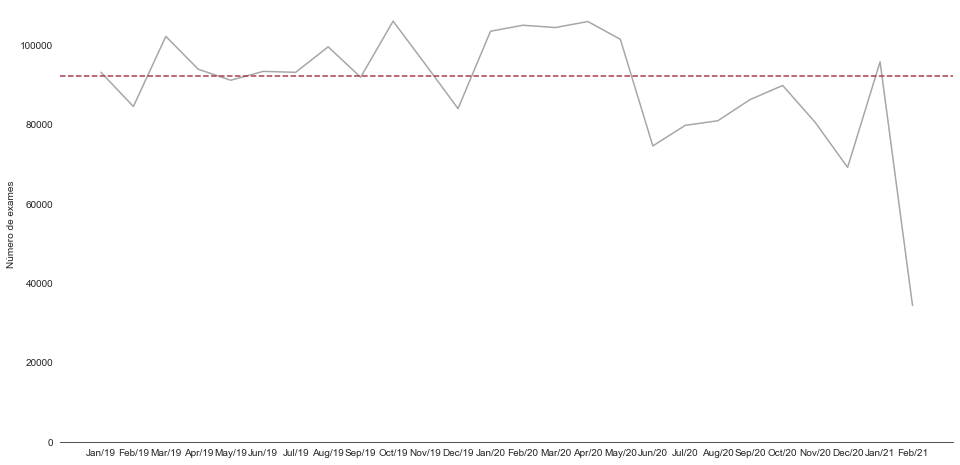

In [5]:
# gráfico

plt.figure(figsize = (16, 8))
sns.set_style('white')
fig = sns.lineplot(data = exames_mes2, x = 'mes_ano', y = 'Número de exames', color = '#a6a6a6')

# remover o título do eixo x
fig.set_xlabel('')

fig.set_ylim(0,)
# remover as bordas do gráfico
sns.despine(left = True)


# adicionar linha vertical em y = média de exames por mês
plt.axhline(y = 92254.2, linestyle='--', color='#ac3a4e')

### gráfico de mapa com bolhas com o valor médio dos exames por laboratório

In [7]:
transactional_data

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Valor Pago,Idade,final_id,mes,ano,mes_ano
0,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,42.0,BIO003,Jan,19,Jan/19
1,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000638,13.0,42.0,BIO003,Jan,19,Jan/19
2,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70001597,49.0,42.0,BIO003,Jan,19,Jan/19
3,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000103,11.0,42.0,BIO003,Jan,19,Jan/19
4,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000224,10.0,42.0,BIO003,Jan,19,Jan/19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2340717,7664157546-1,M,1971-03-06,2021-02-12,7664157546-1-1,L697,70004038,10.0,49.0,1,Feb,21,Feb/21
2340718,7664157546-1,M,1971-03-06,2021-02-12,7664157546-1-1,L697,70004134,10.0,49.0,1,Feb,21,Feb/21
2340719,7664157546-1,M,1971-03-06,2021-02-12,7664157546-1-1,L697,70003056,9.0,49.0,1,Feb,21,Feb/21
2340720,7664157546-1,M,1971-03-06,2021-02-12,7664157546-1-1,L697,70004185,13.0,49.0,1,Feb,21,Feb/21


In [10]:
coordenadas = df_geocode

# separando a latitude e a longitude
coordenadas['latitude'] = coordenadas['Location'].str.split(',').str[0].astype('float')
coordenadas['longitude'] = coordenadas['Location'].str.split(',').str[1].astype('float')

# separando o estado a partir da coluna de endereço
coordenadas['Sigla'] = coordenadas['Address'].str.split(', ').str[2].str.split(' ').str[0]

# calculando o preço médio dos exames
media_preco_exames = transactional_data.groupby('Lab Id').mean()[['Valor Pago']].reset_index()
media_preco_exames

coordenadas = coordenadas.merge(media_preco_exames, how = 'left')
coordenadas = coordenadas.rename({'Valor Pago':'Média Valor Pago'}, axis = 1)
coordenadas['Média Valor Pago'] = coordenadas['Média Valor Pago'].fillna(0)
coordenadas

,Lab Id,Address,Location,Zipcode,latitude,longitude,Sigla,Média Valor Pago
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0,34.000319,-84.162972,GA,65.259434
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0,43.231133,-75.444536,NY,28.328888
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0,47.716279,-122.183815,WA,54.728232
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0,33.909388,-84.352910,GA,27.701021
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0,40.930993,-90.943760,IL,31.383244
...,...,...,...,...,...,...,...,...
113,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002.0,39.918408,-75.035649,NJ,45.046184
114,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421.0,43.077370,-75.653690,NY,34.661707
115,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304.0,43.253010,-75.186002,NY,26.296361
116,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806.0,41.561118,-90.591518,IA,41.150734


In [11]:
scl = [[0.0, '#ac3a4e'],[1.0, '#5288db']]

data = dict(
    type = 'scattergeo',
    # colorscale = 'RdBu',
    lat = coordenadas['latitude'],
    lon = coordenadas['longitude'],
    # locations = coordenadas['state'],
    # locationmode = 'USA-states',
    # z = coordenadas['Lab Id'],
    # text = coordenadas['Address'],
    marker = dict(size = coordenadas['Média Valor Pago']/3, autocolorscale = False, colorscale = scl, color = coordenadas['Média Valor Pago'], 
                  # colorbar = dict(title = 'Valor médio')
                  ),
    # colorbar = dict(title = 'Zipcode')
)

layout = dict(
    # title = 'Média do valor pago nos exames em cada laboratório',
    geo = dict(scope = 'usa', # showlakes = True, lakecolor = 'rgb(85, 173, 240)',
               projection = dict(type ='albers usa'),showland = True,
                    landcolor="rgb(250,250,250)",subunitcolor = "rgb(100,100,100)",
                     countrycolor = "rgb(100,100,100)",countrywidth =0.5, subunitwidth=0.5)
)

choromap = go.Figure(data = [data], layout = layout)


choromap.update_layout(width = 600)
iplot(choromap, validate = False)

### percentual de clientes entre 30 e 65 anos

In [12]:
def faixa_etaria(x):
    if x < 30 :
        return 'menos de 30 anos'
    elif x <= 65:
        return 'entre 30 e 65 anos'
    elif x > 65:
        return 'mais de 65 anos'


pacientes_unicos = transactional_data.drop_duplicates(subset = 'Patient Id')
pacientes_unicos['faixa etaria'] = pacientes_unicos['Idade'].apply(faixa_etaria)

total_idade = pacientes_unicos['faixa etaria'].value_counts().to_frame()
total_idade['total'] = total_idade['faixa etaria'].sum()
total_idade['perc'] = total_idade['faixa etaria'] * 100 / total_idade['total']
total_idade

C:\Users\Leticia\AppData\Local\Temp\ipykernel_23228\2151088617.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,faixa etaria,total,perc
entre 30 e 65 anos,324530,501445,64.718962
menos de 30 anos,148007,501445,29.516098
mais de 65 anos,28908,501445,5.764939


### gráfico final id paciente

In [32]:
padrao_id_paciente = transactional_data[['Patient Id']].drop_duplicates()
padrao_id_paciente['final_cod'] = padrao_id_paciente['Patient Id'].str.split('-').str[-1]
padrao_id_paciente = padrao_id_paciente['final_cod'].value_counts().to_frame().reset_index()

padrao_id_paciente = padrao_id_paciente[padrao_id_paciente['index'] != "2"]

padrao_id_paciente

,index,final_cod
0,1,304822
1,BIO003,91708
2,BIO002,66762
3,BIO010,36127
4,UND2243,1788
5,UND2113,238


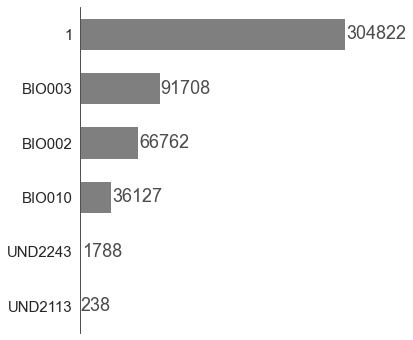

In [33]:
plt.figure(figsize = (5,6))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = padrao_id_paciente, x = 'final_cod', y = 'index', color = '#7f7f7f', width = 0.6)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate(int(i.get_width()),
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 18,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')
fig.set_yticklabels(fig.get_yticklabels(), fontsize=15)

# remover os títulos dos eixos
fig.set(xlabel='', ylabel='')

# remover as bordas do gráfico
sns.despine(bottom = True)

### treemap categorias dos exames

In [35]:
categorias_testes = test_data.groupby(['Category', 'Family', 'Speciality']).count()[['CodItem']].reset_index()
categorias_testes

,Category,Family,Speciality,CodItem
0,CA,COPRO,HIDDEN BLOOD,1
1,CA,COPRO,PARASITOLOGY,5
2,CA,COPRO,SPECIAL COPRO,18
3,CA,CORELAB,ALLERGY,182
4,CA,CORELAB,AUTOIMMUNITY,2
...,...,...,...,...
88,RID,ULTRASOUND,GENERAL,30
89,RID,ULTRASOUND,INVASIVE PROCEDURE,6
90,RID,ULTRASOUND,SKELETAL MUSCLE,28
91,RID,X-RAY,CONVENTIONAL,70


In [36]:
colors = ['#D9D9D9', '#59220E', '#BF9D7E', '#8C7D77', '#733C30', '#ac3a4e']

fig = px.treemap(categorias_testes,
                 path=["Category","Family","Speciality"],
                 values='CodItem',
                 color='Category',
                 color_discrete_sequence = colors,
                 width=1000, height=700,
                 title="Testes por Category, Family e Speciality",)

fig.show()

In [8]:
colors = ['#DF8C37', '#C74458', '#618E8C', '#98B2E1', '#8D8D8D', '#3860A5']

fig = px.treemap(categorias_testes,
                 path=["Category","Family","Speciality"],
                 values='CodItem',
                 color='Category',
                 color_discrete_sequence = colors,
                 width=1000, height=700,
                 title="Testes por Category, Family e Speciality",)

fig.show()

### média geral do número de exames por bateria

In [21]:
transactional_data.groupby(['Service Id']).count().reset_index()['Patient Id'].mean()

3.5462314732470883

### gráfico do número de exames

In [71]:
n_exames_lab = transactional_data.groupby('Lab Id').count()[['CodItem']].reset_index().merge(df_geocode[['Lab Id', 'Sigla']], how = 'left')
n_exames_lab = n_exames_lab[n_exames_lab['Lab Id'] != "-2"]

def color_states(x):
    if x == 'CA':
        return '#5288db'
    if x == 'GA':
        return '#ac3a4e'
    
n_exames_lab['cor'] = n_exames_lab['Sigla'].apply(color_states)
n_exames_lab_low = pd.concat([n_exames_lab.sort_values('CodItem', ascending = False).tail(10)])
n_exames_lab_low

,Lab Id,CodItem,Sigla,cor
106,L698,1943,WA,None
67,L518,1916,CA,#5288db
108,L720,1835,WA,None
100,L666,1288,GA,#ac3a4e
63,L442,1174,WA,None
95,L660,645,NH,None
25,L127,235,LA,None
117,L967,90,CA,#5288db
39,L149,68,CA,#5288db
99,L665,24,NaN,None


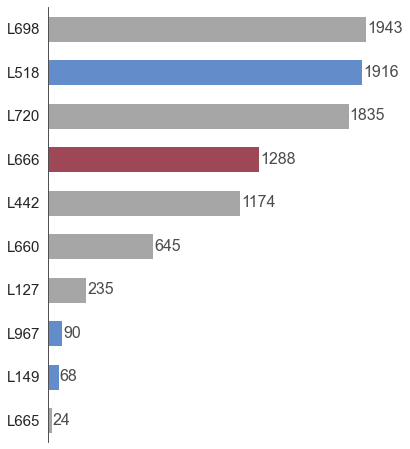

In [73]:
cores = ['#ac3a4e' if x == 'GA' else '#5288db' if x == 'CA' else '#a6a6a6' for x in n_exames_lab_low['Sigla']]

plt.figure(figsize = (6,8))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = n_exames_lab_low, x = 'CodItem', y = 'Lab Id', palette = cores, width = 0.6)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate(int(i.get_width()),
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 16,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')
fig.set_yticklabels(fig.get_yticklabels(), fontsize=15)

# remover os títulos dos eixos
fig.set(xlabel='', ylabel='')

# remover as bordas do gráfico
sns.despine(bottom = True)


In [79]:
# primeiro exame de alguns laboratórios

transactional_data[transactional_data['Lab Id'] == 'L665'].sort_values('Date of service').head()

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Valor Pago,Idade,final_id,mes,ano,mes_ano
15790,10240382020-BIO010,M,1961-01-14,2019-01-17,537300215155-142,L665,70000972,38.0,58.0,BIO010,Jan,19,Jan/19
21221,10240382026-BIO010,F,1990-12-31 00:00:00,2019-01-17,537300215193-142,L665,70000972,38.0,28.0,BIO010,Jan,19,Jan/19
157408,10240382027-BIO010,F,2017-11-20 00:00:00,2019-01-17,537300215209-142,L665,70000972,38.0,1.0,BIO010,Jan,19,Jan/19
180798,10240382022-BIO010,M,1954-08-20,2019-01-17,537300215162-142,L665,70000972,38.0,64.0,BIO010,Jan,19,Jan/19
199212,10240382025-BIO010,F,1981-11-20 00:00:00,2019-01-17,537300215186-142,L665,70000972,38.0,37.0,BIO010,Jan,19,Jan/19


### número de exames por estado

In [105]:
# número de laboratórios por estado
n_lab_estados = df_geocode.groupby('Sigla').count()[['Lab Id']].reset_index()

# média de exames por estado
n_exames_estado = transactional_data.merge(df_geocode[['Lab Id', 'Sigla']], how = 'left').groupby('Sigla').count()[['CodItem']].reset_index()
n_exames_estado = n_exames_estado.merge(n_lab_estados, how = 'left')
n_exames_estado['media_exames_estado'] = round(n_exames_estado['CodItem'] / n_exames_estado['Lab Id'], 1)
n_exames_estado = n_exames_estado.sort_values('media_exames_estado', ascending = False).merge(zipcodes_states[['Sigla', 'Estado']], how = 'left')
n_exames_estado


,Sigla,CodItem,Lab Id,media_exames_estado,Estado
0,PA,466811,17,27459.5,Pennsylvania
1,CA,477651,18,26536.2,California
2,GA,442417,18,24578.7,Georgia
3,WA,459521,20,22976.0,Washington
4,MI,44078,2,22039.0,Michigan
5,MA,182072,12,15172.7,Massachusetts
6,IA,58729,5,11745.8,Iowa
7,TX,10922,1,10922.0,Texas
8,IL,60481,6,10080.2,Illinois
9,NJ,26853,3,8951.0,New Jersey


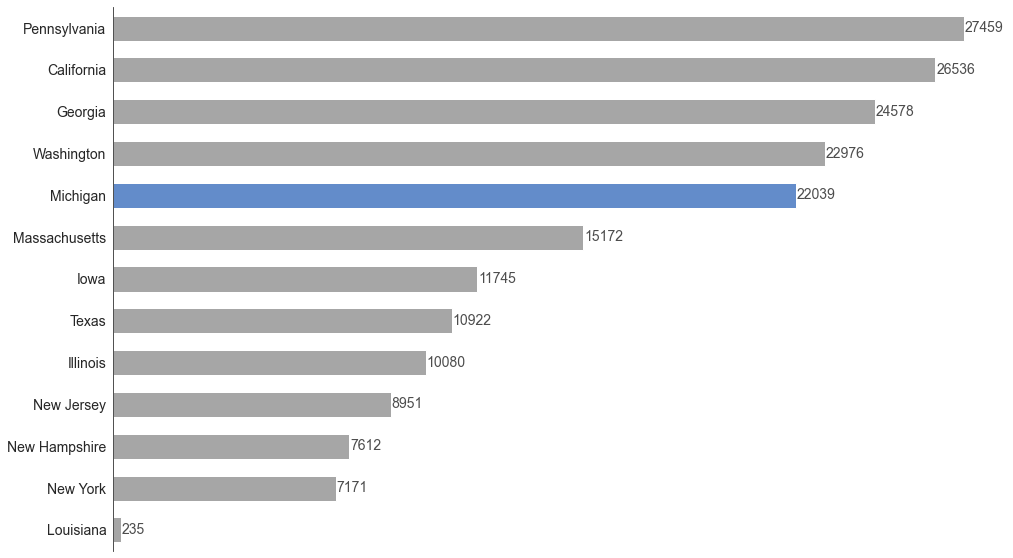

In [166]:
cores = ['#5288db' if x == 'Michigan' else '#a6a6a6' for x in n_exames_estado['Estado']]

plt.figure(figsize = (16,10))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = n_exames_estado, x = 'media_exames_estado', y = 'Estado', palette = cores, width = 0.6)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate(int(i.get_width()),
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 14,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')
fig.set_yticklabels(fig.get_yticklabels(), fontsize=14)

# remover os títulos dos eixos
fig.set(xlabel='', ylabel='')

# remover as bordas do gráfico
sns.despine(bottom = True)

### gráfico da receita dos laboratórios

In [136]:
receita = transactional_data.groupby("Lab Id").sum()[['Valor Pago']].reset_index()
receita = receita[receita['Lab Id'] != '-2'].sort_values('Valor Pago', ascending = False)
receita['label'] = (round(receita['Valor Pago'] / 1000000, 1)).astype(str) + ' M'

receita = receita.head(10).merge(df_geocode[['Lab Id', 'Sigla']], how = 'left')

receita

,Lab Id,Valor Pago,label,Sigla
0,L133,9711866.14,9.7 M,CA
1,L139,8778103.04,8.8 M,CA
2,L121,6521202.54,6.5 M,WA
3,L123,6372571.60,6.4 M,PA
4,L152,6216352.62,6.2 M,GA
5,L155,5278574.40,5.3 M,CA
6,L156,5081689.03,5.1 M,WA
7,L166,4721055.04,4.7 M,PA
8,L662,4014292.96,4.0 M,GA
9,L061,3381442.96,3.4 M,WA


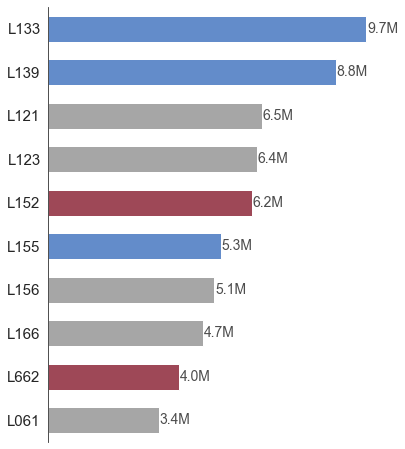

In [138]:
cores = ['#ac3a4e' if x == 'GA' else '#5288db' if x == 'CA' else '#a6a6a6' for x in receita['Sigla']]

plt.figure(figsize = (6,8))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = receita, x = 'Valor Pago', y = 'Lab Id', palette = cores, width = 0.6)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate((round(i.get_width() / 1000000, 1)).astype(str) + 'M',
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 14,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')
fig.set_yticklabels(fig.get_yticklabels(), fontsize=15)

# remover os títulos dos eixos
fig.set(xlabel='', ylabel='')

# remover as bordas do gráfico
sns.despine(bottom = True)

### gráfico de fidelização por estado

In [152]:
fidelizacao = transactional_data[transactional_data['Patient Id'] != '-2']
fidelizacao = fidelizacao[fidelizacao['Lab Id'] != '-2']

fidelizacao = fidelizacao.merge(df_geocode[['Lab Id', 'Sigla']]).merge(zipcodes_states[['Sigla', 'Estado']], how = 'left')

fidelizacao = fidelizacao.groupby(['Patient Id', 'Estado']).count().reset_index().drop_duplicates('Patient Id')[['Patient Id', 'Estado', 'Gender']]

fidelizacao = fidelizacao.rename({'Gender': 'Média de idas ao lab'}, axis = 1)

fidelizacao_estado = fidelizacao.groupby('Estado').mean('Média de idas ao lab').reset_index().sort_values('Média de idas ao lab', ascending = False)

fidelizacao_estado

,Estado,Média de idas ao lab
6,Michigan,5.068380
7,New Hampshire,4.924237
2,Illinois,4.814456
8,New Jersey,4.716565
11,Texas,4.527517
1,Georgia,4.480087
3,Iowa,4.390296
5,Massachusetts,4.372163
9,New York,4.358783
10,Pennsylvania,4.358582


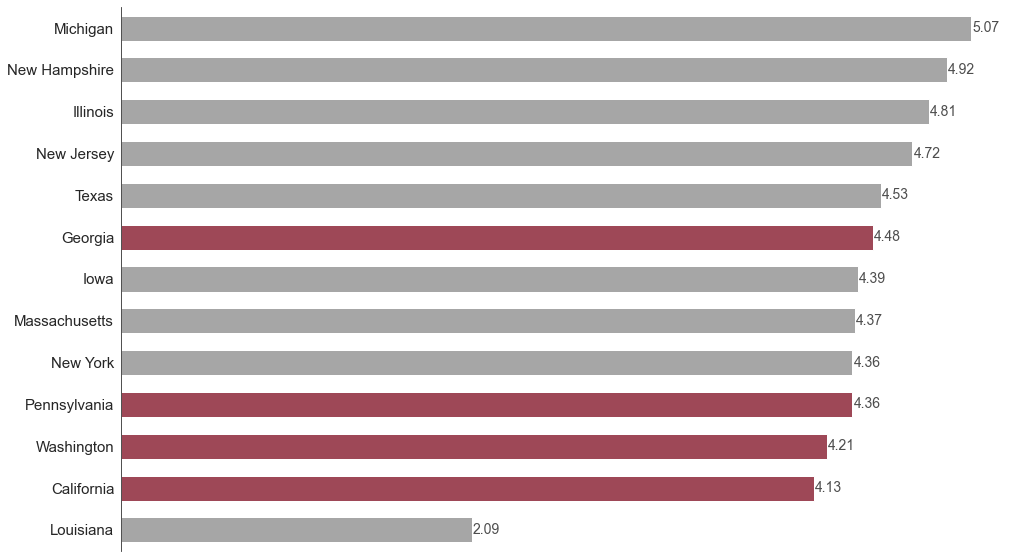

In [157]:
cores = ['#ac3a4e' if x == 'California' else '#ac3a4e' if x == 'Washington' else '#ac3a4e' if x == 'Georgia' else '#ac3a4e' if x == 'Pennsylvania' else '#a6a6a6' for x in fidelizacao_estado['Estado']]

plt.figure(figsize = (16,10))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = fidelizacao_estado, x = 'Média de idas ao lab', y = 'Estado', palette = cores, width = 0.6)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate(float(round(i.get_width(), 2)),
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 14,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')
fig.set_yticklabels(fig.get_yticklabels(), fontsize=15)

# remover os títulos dos eixos
fig.set(xlabel='', ylabel='')

# remover as bordas do gráfico
sns.despine(bottom = True)

### gráfico de fidelização dos laboratórios

In [143]:
fidelizacao = transactional_data[transactional_data['Patient Id'] != '-2']

fidelizacao = fidelizacao[fidelizacao['Lab Id'] != '-2']

fidelizacao = fidelizacao.groupby(['Patient Id', 'Lab Id']).count().reset_index().drop_duplicates('Patient Id')[['Patient Id', 'Lab Id', 'Gender']]

fidelizacao = fidelizacao.rename({'Gender': 'Média de idas ao lab'}, axis = 1)

fidelizacao = fidelizacao.groupby('Lab Id').mean('Média de idas ao lab').reset_index().sort_values('Média de idas ao lab', ascending = False).head(10).merge(df_geocode[['Lab Id', 'Sigla']], how = 'left')

fidelizacao

,Lab Id,Média de idas ao lab,Sigla
0,L525,6.362271,PA
1,L144,5.730931,NH
2,L122,5.581476,WA
3,L545,5.572115,IL
4,L537,5.534304,NJ
5,L768,5.439044,PA
6,L134,5.365709,GA
7,L072,5.288708,GA
8,L531,5.246493,CA
9,L131,5.221505,MI


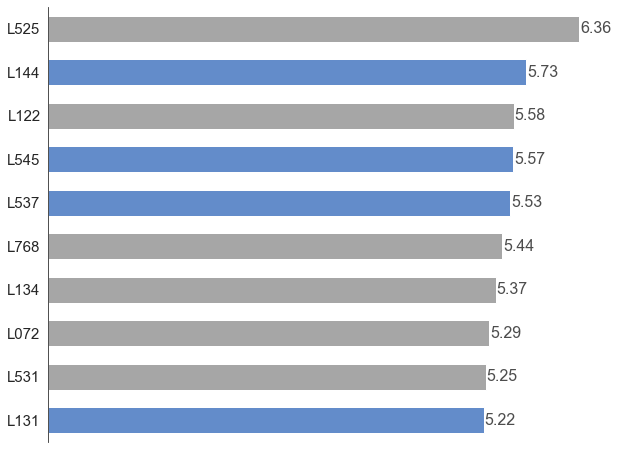

In [149]:
cores = ['#5288db' if x == 'NH' else '#5288db' if x == 'NJ' else '#5288db' if x == 'MI' else '#5288db' if x == 'IL' else '#a6a6a6' for x in fidelizacao['Sigla']]

plt.figure(figsize = (10,8))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = fidelizacao, x = 'Média de idas ao lab', y = 'Lab Id', palette = cores, width = 0.6)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate(float(round(i.get_width(), 2)),
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 16,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')
fig.set_yticklabels(fig.get_yticklabels(), fontsize=15)

# remover os títulos dos eixos
fig.set(xlabel='', ylabel='')

# remover as bordas do gráfico
sns.despine(bottom = True)

### gráfico média de exames por bateria

In [160]:
transactional_location = transactional_data.merge(df_geocode[['Lab Id', 'Sigla']], how = 'left')

transactional_location.head()

media_bateria_estado = transactional_location.groupby(['Sigla', 'Service Id']).count()['Patient Id'].reset_index()

media_bateria_estado = media_bateria_estado.groupby('Sigla').mean('Patient Id').reset_index()

media_bateria_estado = media_bateria_estado.sort_values('Patient Id', ascending = False).reset_index().rename({'Patient Id': 'Média de exames por bateria'}, axis = 1).merge(zipcodes_states[['Sigla', 'Estado']], how = 'left')

media_bateria_estado

,index,Sigla,Média de exames por bateria,Estado
0,6,MI,4.195907,Michigan
1,7,NH,4.134845,New Hampshire
2,3,IL,3.912349,Illinois
3,8,NJ,3.886670,New Jersey
4,1,GA,3.644472,Georgia
5,5,MA,3.615409,Massachusetts
6,10,PA,3.557441,Pennsylvania
7,2,IA,3.535974,Iowa
8,9,NY,3.512936,New York
9,12,WA,3.483885,Washington


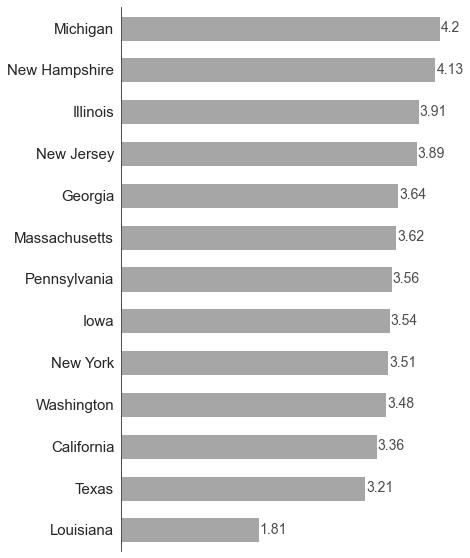

In [164]:
plt.figure(figsize = (6,10))
sns.set_style('white') # also 'ticks', 'darkgrid', 'whitegrid', white
fig = sns.barplot(data = media_bateria_estado, x = 'Média de exames por bateria', y = 'Estado', color = '#a6a6a6', width = 0.6)

# colocar os números no final da barra
for i in fig.patches:
    fig.annotate((round(i.get_width(), 2)),
                  (i.get_width(), i.get_y() + i.get_height() / 2),
                  ha = 'left', va = 'center', fontsize = 14,
                  color = '#4d4d4d', xytext = (1, 0),
                  textcoords = 'offset points')

# remover os números do eixo x
fig.set_xticklabels('')
fig.set_yticklabels(fig.get_yticklabels(), fontsize=15)

# remover os títulos dos eixos
fig.set(xlabel='', ylabel='')

# remover as bordas do gráfico
sns.despine(bottom = True)

# deixar o gráfico transparente
plt.gcf().set_facecolor('none')
plt.gca().patch.set_alpha(0)